# cuDatashader GPU FDEB Edge Bundling demo

In this demo, we demonstrate GPU FDEB Edge Bundling demo on US air traffic

In [1]:
import math
import numpy as np
import pandas as pd

import cudatashader as ds
import cudatashader.transfer_functions as tf
from cudatashader.bundling import fdeb_bundle, connect_edges

import cudf
import time

np.set_printoptions(threshold=np.inf)

In [2]:
from pyproj import Proj, transform

sx, tx = 7.069645631678011e-07, 10.230198646765354
sy, ty = 1.2444518695402388e-06, -3.1391195482943135

airports = pd.read_csv('data/airports.csv') # List of airports (our nodes)
airports['AIRPORT_ID'] = airports['AIRPORT_ID'] - 10001

inProj = Proj(init='epsg:4326') # GPS data (latitude, longitude)
outProj = Proj(init='epsg:3857') # Plottable 2D points

x, y = transform(inProj, outProj, airports['LONGITUDE'].values, airports['LATITUDE'].values) # Conversion from GPS data to 2D points

# Very important! For now the GPU FDEB Edge Bundling only work when the graph is scaled appropriately
airports['x'] = x * sx + tx
airports['y'] = y * sy + ty

airports.drop(['LATITUDE', 'LONGITUDE'], axis=1, inplace=True)
airports = airports[~airports.isin([np.nan, np.inf, -np.inf]).any(1)]

to_complete_dataset = pd.DataFrame({'AIRPORT_ID': np.arange(len(airports))})
airports = to_complete_dataset.merge(airports, how='left')
airports.drop(['AIRPORT_ID'], axis=1, inplace=True)
airports.fillna(0.0, inplace=True)

airports = cudf.DataFrame.from_pandas(airports)
airports.to_pandas().head()

,x,y
0,-1.803393,6.804479
1,0.000000,0.000000
2,-2.445970,8.999557
3,-2.610844,9.892539
4,-1.431716,9.704107


In [3]:
flights = pd.read_csv('data/flights.csv') # List of flights (our edges)
flights = flights[flights['PASSENGERS'] > 10000] # Filter over flights having more than 10000 passengers
flights.drop(['PASSENGERS'], axis=1, inplace=True)
flights['ORIGIN_AIRPORT_ID'] = flights['ORIGIN_AIRPORT_ID'] - 10001
flights['DEST_AIRPORT_ID'] = flights['DEST_AIRPORT_ID'] - 10001
flights.rename(columns = {'ORIGIN_AIRPORT_ID': 'x', 'DEST_AIRPORT_ID': 'y'}, inplace=True)
flights = flights.drop_duplicates(keep='first')
flights['sum'] = flights['x'] + flights['y']
flights = flights.drop_duplicates(subset=['sum'], keep='first') # Avoiding overlaying edges (flight back and forth from same 2 airports)
flights = cudf.DataFrame.from_pandas(flights)
flights.to_pandas().head()

,x,y,sum
292793,5015,692,5707
292794,422,1291,1713
292795,2888,3486,6374
292796,4056,2888,6944
292797,4491,396,4887


In [4]:
def nodesplot(nodes, canvas=None, cat=None): # Plot nodes
    canvas = ds.Canvas(plot_height=1080, plot_width=1920) if canvas is None else canvas
    agg = canvas.points(nodes, 'x','y', ds.any('x'))
    img = tf.shade(agg, cmap=['white', 'green'], how='log')
    return tf.spread(img, px=4, shape='circle', how='over')

def edgesplot(edges, canvas=None): # Plot edges
    canvas = ds.Canvas(plot_height=1080, plot_width=1920) if canvas is None else canvas
    agg = canvas.line(edges, 'x','y')
    img = tf.shade(agg, how='linear')
    return img

def graphplot(nodes, edges, canvas=None, cat=None): # Plot graph (nodes + edges)
    if canvas is None:
        xr = -14470596.094555834 * sx + tx, -7398105.816407016 * sx + tx
        yr = 2522491.729193237 * sy + ty, 6540324.899267741 * sy + ty
        canvas = ds.Canvas(plot_height=1080, plot_width=1920, x_range=xr, y_range=yr)

    ep = edgesplot(edges, canvas) # Plot nodes
    np = nodesplot(nodes, canvas, cat) # Plot edges
    return tf.stack(ep, np, how="over") # Stack two images for final render

## First, without Edge Bundling

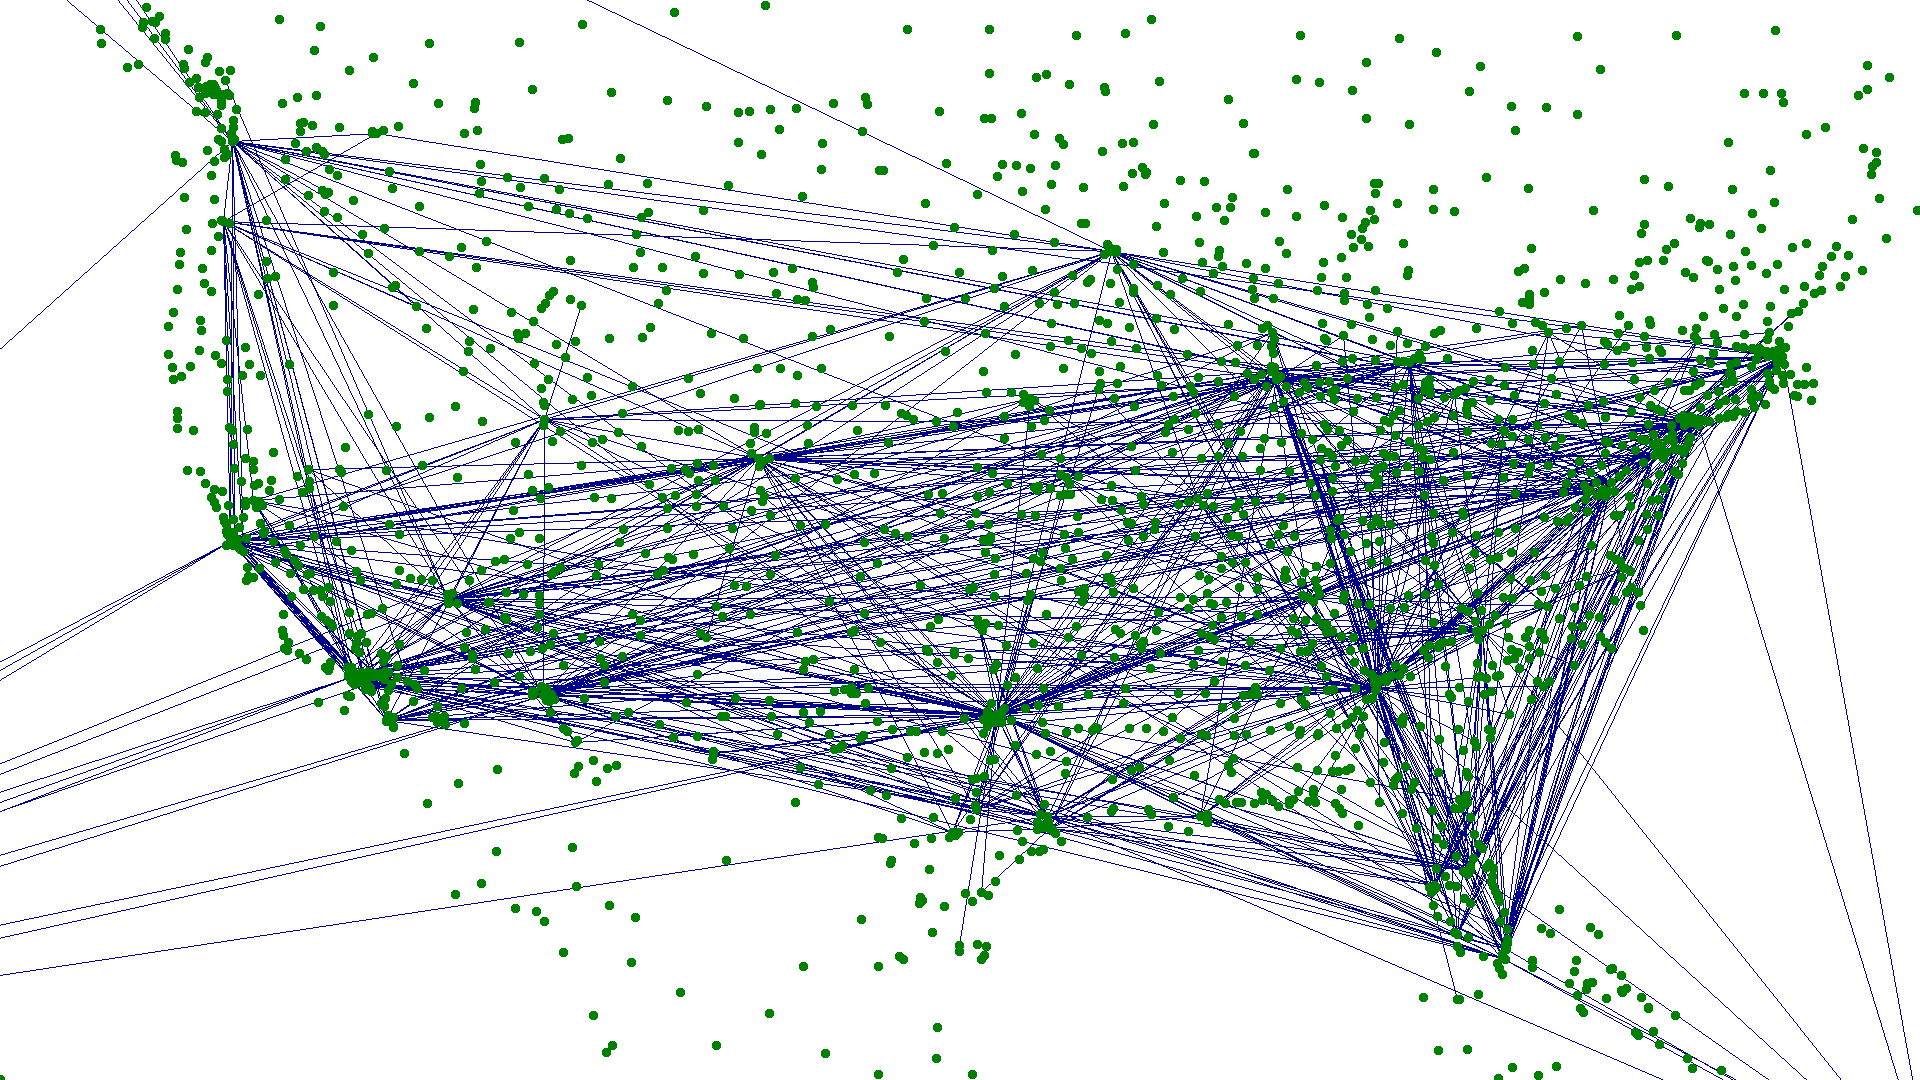

In [5]:
edges = connect_edges(airports, flights) # Simply connect edges (instead of edge bundling)
graphplot(airports, edges) # Plot graph

## Then, with Edge Bundling

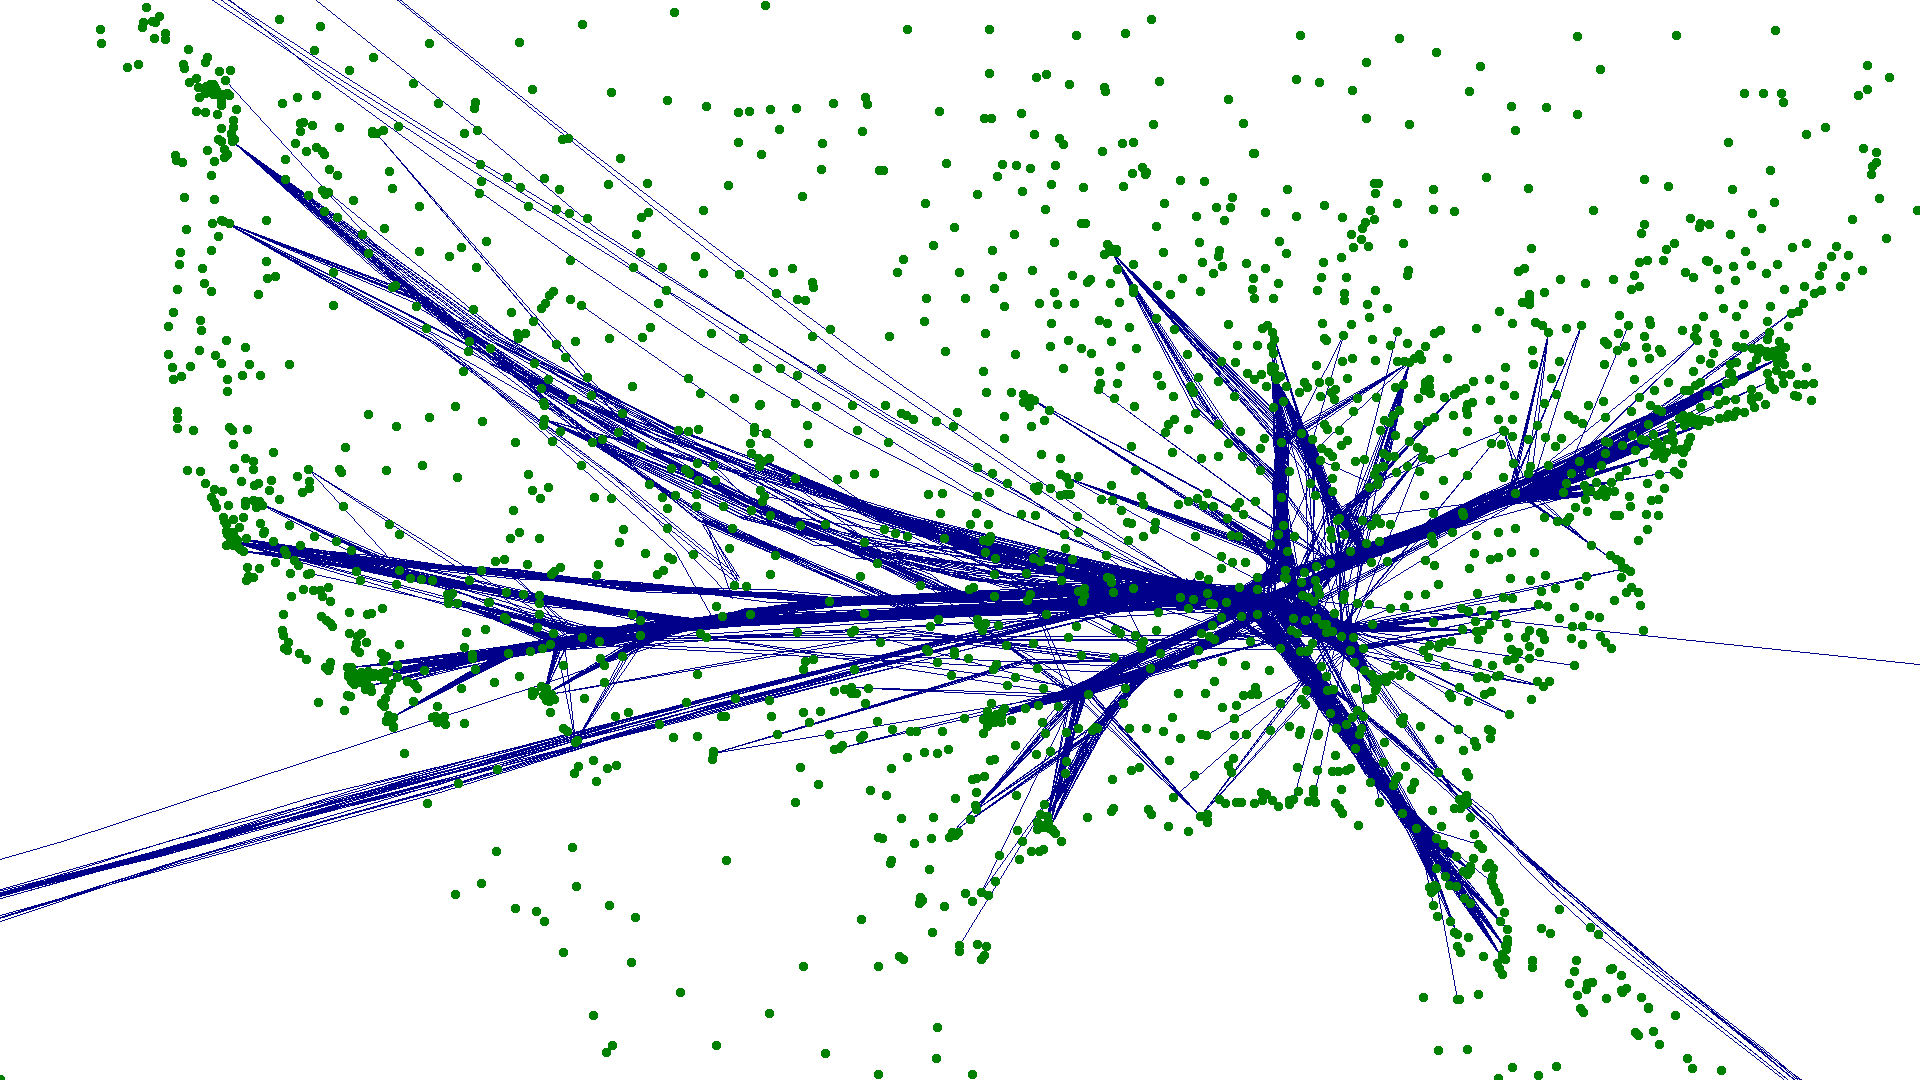

In [6]:
params = {
    'C': 5,   # number of cycles
    'I': 250, # number of iteration steps in a cycle
    'S': 0.4, # step size
    'K': 0.2  # stiffness factor
}

edges = fdeb_bundle(airports, flights, params) # Apply edge bundling with special parameters
graphplot(airports, edges) # Plot graph

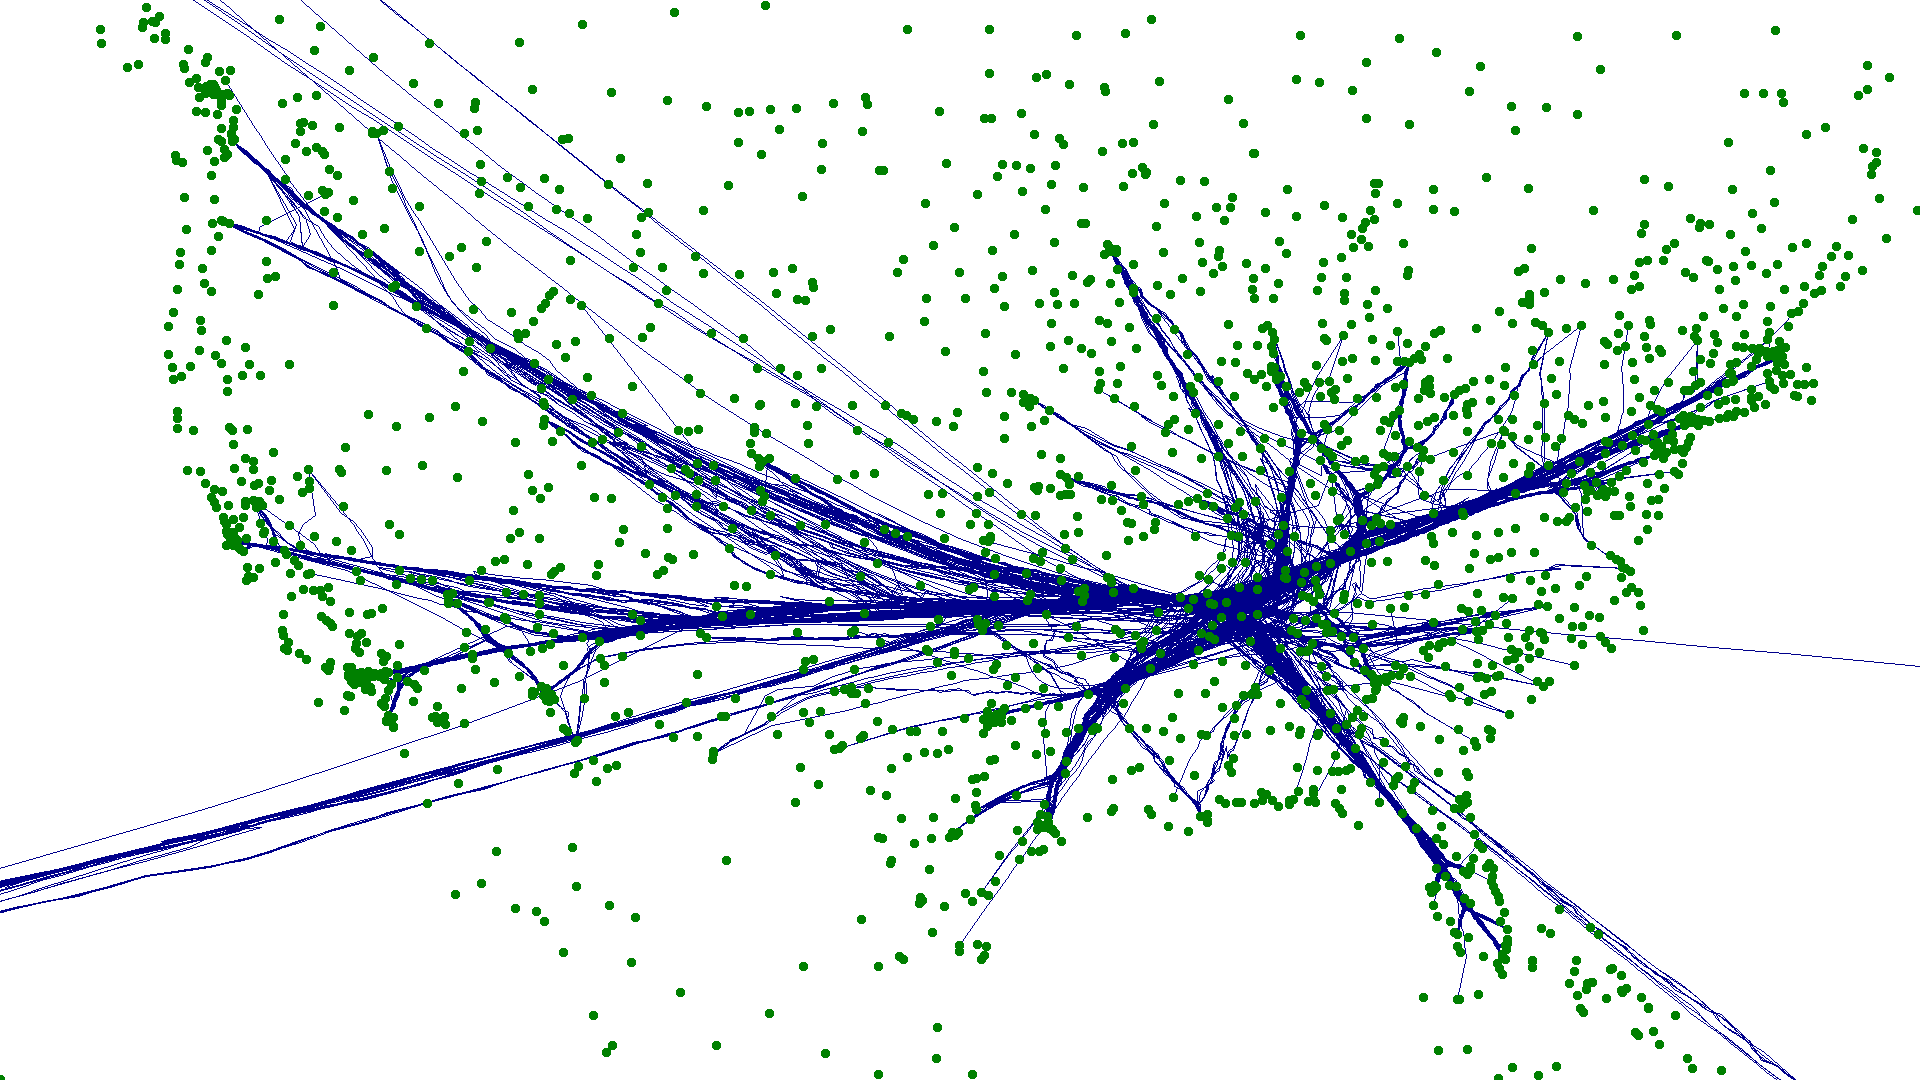

In [7]:
params = {
    'C': 8,   # number of cycles
    'I': 500, # number of iteration steps in a cycle
    'S': 0.8, # step size
    'K': 0.4  # stiffness factor
}

edges = fdeb_bundle(airports, flights, params) # Apply edge bundling with special parameters
graphplot(airports, edges) # Plot graph